# VGGFace Deep Convolutional Network

## Motivation
Facial Recognition research has found extensive applications for convolutional neural networks. We have attemped to analyse the performance of existing neural networks such as VGG Face and test the accuracy of the model using K-nearest neighbours. By training the last layer (the embedding layer) of the network on a small dataset in comparison to research papers that have extensive data sources and resources, we hope to replicate functionalities of face recognition using K nearest neighbours. In short, we calculate the face embedding of an image and compares its face embedding vector with all the embedding vectors of all the faces in database, and we choose the K nearest faces using euclidean distance. By doing so, we hope to show the minimal data necessary to accurately have a face recognition system.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class VGGFace(nn.Module):
    def __init__(self, in_channels, num_classes=2622, init_weights=True):
        super(VGGFace, self).__init__()
        self.init_weights = init_weights
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # 1
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            #5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        )

        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)
    

    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

c:\Users\Matthew\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get the weights from a trained VGG face model and transfer the weights to our VGG Face model.
A person on github trained the convolutional neural network of VGG Face that supports image classification on the 2622 unique identities found in this paper https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf. The link to his git repository can be found here https://github.com/claudio-unipv/vggface-pytorch.

The pytorch pretrained model of the VGG face is found in the assets link https://github.com/claudio-unipv/vggface-pytorch/releases. Once this file `vggface-9d491dd7c30312.pth` has been download, place the file in a directory called `misc` under the root directory.

In [3]:
# This is somebody else trained model
# Download the weights from here https://github.com/claudio-unipv/vggface-pytorch/releases called vggface-9d491dd7c30312.pth
# Create a directory called 'misc' in the root directory and place this file vggface-9d491dd7c30312.pth into misc directory

def pretrainedVggface(pretrained=True, **kwargs):
    """VGGFace model.
    Args:
        pretrained (bool): If True, returns pre-trained model 
    """
    model = VggFace(**kwargs)
    if pretrained:
        model.load_state_dict(torch.load('misc/vggface-9d491dd7c30312.pth'))
    return model


class VggFace(torch.nn.Module):
    def __init__(self, classes=2622):
        """VGGFace model.
        Face recognition network.  It takes as input a Bx3x224x224
        batch of face images and gives as output a BxC score vector
        (C is the number of identities).
        Input images need to be scaled in the 0-1 range and then 
        normalized with respect to the mean RGB used during training.
        Args:
            classes (int): number of identities recognized by the
            network
        """
        super().__init__()
        self.conv1 = _ConvBlock(3, 64, 64)
        self.conv2 = _ConvBlock(64, 128, 128)
        self.conv3 = _ConvBlock(128, 256, 256, 256)
        self.conv4 = _ConvBlock(256, 512, 512, 512)
        self.conv5 = _ConvBlock(512, 512, 512, 512)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(7 * 7 * 512, 4096)
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.fc3 = torch.nn.Linear(4096, classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


class _ConvBlock(torch.nn.Module):
    """A Convolutional block."""

    def __init__(self, *units):
        """Create a block with len(units) - 1 convolutions.
        convolution number i transforms the number of channels from 
        units[i - 1] to units[i] channels.
        """
        super().__init__()
        self.convs = torch.nn.ModuleList([
            torch.nn.Conv2d(in_, out, 3, 1, 1)
            for in_, out in zip(units[:-1], units[1:])
        ])
        
    def forward(self, x):
        # Each convolution is followed by a ReLU, then the block is
        # concluded by a max pooling.
        for c in self.convs:
            x = F.relu(c(x))
        return F.max_pool2d(x, 2, 2, 0, ceil_mode=True)
    

In [4]:
# Copy the weights from the pretrained model into our model

pretrainedVgg = pretrainedVggface(pretrained=True)
nontrainedVgg = VGGFace(in_channels=3)
# 1
nontrainedVgg.conv_layers[0].weight.data.copy_(pretrainedVgg.conv1.convs[0].weight.data)
nontrainedVgg.conv_layers[0].bias.data.copy_(pretrainedVgg.conv1.convs[0].bias.data)
nontrainedVgg.conv_layers[2].weight.data.copy_(pretrainedVgg.conv1.convs[1].weight.data)
nontrainedVgg.conv_layers[2].bias.data.copy_(pretrainedVgg.conv1.convs[1].bias.data)
# 2
nontrainedVgg.conv_layers[5].weight.data.copy_(pretrainedVgg.conv2.convs[0].weight.data)
nontrainedVgg.conv_layers[5].bias.data.copy_(pretrainedVgg.conv2.convs[0].bias.data)
nontrainedVgg.conv_layers[7].weight.data.copy_(pretrainedVgg.conv2.convs[1].weight.data)
nontrainedVgg.conv_layers[7].bias.data.copy_(pretrainedVgg.conv2.convs[1].bias.data)
#3
nontrainedVgg.conv_layers[10].weight.data.copy_(pretrainedVgg.conv3.convs[0].weight.data)
nontrainedVgg.conv_layers[10].bias.data.copy_(pretrainedVgg.conv3.convs[0].bias.data)
nontrainedVgg.conv_layers[12].weight.data.copy_(pretrainedVgg.conv3.convs[1].weight.data)
nontrainedVgg.conv_layers[12].bias.data.copy_(pretrainedVgg.conv3.convs[1].bias.data)
nontrainedVgg.conv_layers[14].weight.data.copy_(pretrainedVgg.conv3.convs[2].weight.data)
nontrainedVgg.conv_layers[14].bias.data.copy_(pretrainedVgg.conv3.convs[2].bias.data)
#4
nontrainedVgg.conv_layers[17].weight.data.copy_(pretrainedVgg.conv4.convs[0].weight.data)
nontrainedVgg.conv_layers[17].bias.data.copy_(pretrainedVgg.conv4.convs[0].bias.data)
nontrainedVgg.conv_layers[19].weight.data.copy_(pretrainedVgg.conv4.convs[1].weight.data)
nontrainedVgg.conv_layers[19].bias.data.copy_(pretrainedVgg.conv4.convs[1].bias.data)
nontrainedVgg.conv_layers[21].weight.data.copy_(pretrainedVgg.conv4.convs[2].weight.data)
nontrainedVgg.conv_layers[21].bias.data.copy_(pretrainedVgg.conv4.convs[2].bias.data)
#5
nontrainedVgg.conv_layers[24].weight.data.copy_(pretrainedVgg.conv5.convs[0].weight.data)
nontrainedVgg.conv_layers[24].bias.data.copy_(pretrainedVgg.conv5.convs[0].bias.data)
nontrainedVgg.conv_layers[26].weight.data.copy_(pretrainedVgg.conv5.convs[1].weight.data)
nontrainedVgg.conv_layers[26].bias.data.copy_(pretrainedVgg.conv5.convs[1].bias.data)
nontrainedVgg.conv_layers[28].weight.data.copy_(pretrainedVgg.conv5.convs[2].weight.data)
nontrainedVgg.conv_layers[28].bias.data.copy_(pretrainedVgg.conv5.convs[2].bias.data)
# Linear layers
nontrainedVgg.linear_layers[0].weight.data.copy_(pretrainedVgg.fc1.weight.data)
nontrainedVgg.linear_layers[0].bias.data.copy_(pretrainedVgg.fc1.bias.data)
nontrainedVgg.linear_layers[3].weight.data.copy_(pretrainedVgg.fc2.weight.data)
nontrainedVgg.linear_layers[3].bias.data.copy_(pretrainedVgg.fc2.bias.data)
nontrainedVgg.linear_layers[6].weight.data.copy_(pretrainedVgg.fc3.weight.data)
nontrainedVgg.linear_layers[6].bias.data.copy_(pretrainedVgg.fc3.bias.data)

# Save the weights to file vggfaceweights.pth
torch.save(nontrainedVgg.state_dict(), 'misc/vggfaceweights.pth')

### Load the weights into a our VGG Face model and replace the last layer with feature embedding layer of 128.
In the last layer, 128 output nodes were chosen because it was a highly used number for training with the triple loss function on smaller datasets. In the paper, 1024 nodes were used in the last layer of the network, however due to time constraints it was safe to train with the number of weights that come with the last layer being 128.

Moreover to train the feature embedding layer (the last layer), we had to freeze all the convolutional layers and linear layers except for the last one. This ensured that the feature extracting aspects of the convolutional layer of the network remains the same.

In [5]:
# Load Model
model = VGGFace(in_channels=3, init_weights=False)
model.load_state_dict(torch.load('misc/vggfaceweights.pth'))

# freeze training for all convolutional layers
for param in model.conv_layers.parameters():
    param.requires_grad = False

# newly created modules have require_grad=True by default
feature_embedding = 128
num_features = model.linear_layers[-1].in_features
features = list(model.linear_layers.children())[:-1] # remove last layer
features.extend([nn.Linear(num_features, feature_embedding)]) # add our layer with 1024 outputs
model.linear_layers = nn.Sequential(*features)

# Freeze all the linear layers except for the last layer
for i, param in enumerate(model.linear_layers.parameters()):
    if (i < 4):
        param.requires_grad = False

model = model.to(device)


## Preprocess Pinterest photos of celebrities
To train the embedding layer of the network, we download a set of pinterest faces from kaggle https://www.kaggle.com/datasets/hereisburak/pins-face-recognition.

Once downloaded, place the images into a directory named `dataset` in the root directory.

The cell below crops all the faces from the images in `dataset` and places it in `dataset_2`

In [15]:
from facenet_pytorch import MTCNN
import shutil
from PIL import Image



# 1. Download images from https://www.kaggle.com/datasets/hereisburak/pins-face-recognition
# 2. Put the image folders of each celebrity into a folder called ./dataset in the root directory of the repository
#       i.e.  dataset/pins Adriana Lima
# 3. Crop all face from photos from the set of pinterest photos and put them in ./dataset_2
mtcnn = MTCNN(image_size=224, margin=0)

path = './dataset'
path2 = './dataset_2'
if os.path.exists(path2):
    shutil.rmtree(path2)
os.makedirs(path2)

list_of_images = []
for dirname in tqdm(os.listdir(path)):
    original_image_folder_path = os.path.join(path, dirname)
    new_image_folder_path = os.path.join(path2, dirname)
    os.mkdir(new_image_folder_path)
    for image_name in os.listdir(original_image_folder_path):
        list_of_images.append(dirname + '/' + image_name)

        img = Image.open(os.path.join(path, dirname, image_name))
        img_cropped = mtcnn(img, save_path=os.path.join(new_image_folder_path, image_name))

100%|██████████| 105/105 [08:27<00:00,  4.83s/it]


## Here we generate sets of triplets such that it can be inputted into the triple loss function.
Below, images from `dataset_2` are used to generate the triplets, which consist of an anchor, positive and negative image. The training and validation set split is 80-20 whereby the total number of triplets used in an epoch for the training set is $80 \times 105 = 8400$ and the total number of triplets in the validation set used in an epoch is $20 \times 105 = 2100$. 

### How the triplet images were generated
In `dataset_2`, there is a folder for each unique identity containing numerous images of that individual. What our algorithm does to generate triplets is that it loops `i` from 1 to 105 and it takes 2 random photos from the `i`th unique identity in the directory `dataset_2`, and then it takes an image from a differing identity, and it repeats this for all the unique 105 identities in the dataset. Hence we are guaranteed 105 anchor/positives of unique individuals. 

In [3]:
import random
import cv2
import os
from PIL import Image

# Write the name of each image into a file called list.txt
path = './dataset_2'
list_of_images = []
for dirname in os.listdir(path):
    image_folder_path = os.path.join(path, dirname)
    for image in os.listdir(image_folder_path):
        list_of_images.append(dirname + '/' + image)

with open('misc/list.txt', 'w') as f:
    for item in list_of_images:
        f.write("%s\n" % item)

# Triplet Generator for photos in ./dataset_2 to use with the triple loss function
class DataGenerator():
    def __init__(self, dataset_path, transform, n_triplets_each=1, shuffle=True):
        self.dataset = self.curate_dataset(dataset_path)
        self.n_triplet_each = n_triplets_each
        self.transform=transform
        self.dataset_path = dataset_path
        self.shuffle = shuffle
        self.no_of_people = len(list(self.dataset.keys()))
        self.train_triplets = self.generate_triplets()

    def generate_triplets(self):    
        triplets = []
        people = list(self.dataset.keys())
        for _ in range(self.n_triplet_each):
            for person in people:
                anchor_index = random.randint(0, len(self.dataset[person])-1)
                a = self.get_image(person, anchor_index)
                
                positive_index = random.randint(0, len(self.dataset[person])-1)
                while positive_index == anchor_index:
                    positive_index = random.randint(0, len(self.dataset[person])-1)
                p = self.get_image(person, positive_index)
                
                negative_person_index = random.randint(0, self.no_of_people - 1)
                negative_person = list(self.dataset.keys())[negative_person_index]
                while negative_person == person:
                    negative_person_index = random.randint(0, self.no_of_people - 1)
                    negative_person = list(self.dataset.keys())[negative_person_index]
                
                negative_index = random.randint(0, len(self.dataset[negative_person])-1)
                n = self.get_image(negative_person, negative_index)
                a = self.transform(a)
                p = self.transform(p)
                n = self.transform(n)
                triplets.append([a, p, n])    
        return triplets

        
    def curate_dataset(self, dataset_path):
        with open('misc/list.txt', 'r') as f:
            dataset = {}
            image_list = f.read().splitlines()
            for image in image_list:
                folder_name, file_name = image.split('/')
                if folder_name in dataset.keys():
                    dataset[folder_name].append(file_name)
                else:
                    dataset[folder_name] = [file_name]
        return dataset
            
    def get_image(self, person, index):
        img = cv2.imread(os.path.join(self.dataset_path, person, self.dataset[person][index]))
        img = cv2.resize(img, (224, 224))
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rgb_img = np.asarray(rgb_img, dtype=np.uint8)
        return rgb_img

tr = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.367035294117647, 0.41083294117647057, 0.5066129411764705), 
                (1, 1, 1)
            )
        ])

batch_size = 105
test_generator = DataGenerator('./dataset_2', transform=tr, n_triplets_each=80)
valid_generator = DataGenerator('./dataset_2', transform=tr, n_triplets_each=20)
train_dataloader = torch.utils.data.DataLoader(dataset=test_generator.train_triplets,
                                               batch_size = batch_size,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_generator.train_triplets,
                                               batch_size=batch_size,
                                               shuffle=True)                                        

The shape of the data is (how many sets of triplets, triplets itself, 3 channels, 224, 224 )

## Train the dataset on the Triple loss function and save weights to 'misc/vggface_embedding_weights.pth'

In [ ]:
# Function to train the last layer of the model
def train(model, trainloader, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        image1 = data[0].float().to(device)
        image2 = data[1].float().to(device)
        image3 = data[2].float().to(device)
        optimizer.zero_grad()
        anchor = model(image1)
        positive = model(image2)
        negative = model(image3)
        loss = criterion(anchor, positive, negative)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_running_loss / counter
    return epoch_loss

def validate(model, testloader, criterion):
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            counter += 1
            image1 = data[0].float().to(device)
            image2 = data[1].float().to(device)
            image3 = data[2].float().to(device)
            anchor = model(image1)
            positive = model(image2)
            negative = model(image3)
            loss = criterion(anchor, positive, negative)
            valid_running_loss += loss.item()
    epoch_loss = valid_running_loss / counter
    return epoch_loss

epochs = 11
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
train_loss = []
valid_loss = []
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, train_dataloader, 
                                              optimizer, triplet_loss)
    valid_epoch_loss = validate(model, valid_dataloader,  
                                                 triplet_loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}")

    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': (train_epoch_loss, valid_epoch_loss),
        }, f'save_check_point_epoch_{epoch}.pt')

torch.save(model.state_dict(), 'misc/vggface_embedding_weights.pth')

## Graph the result of the Training loss and validation loss of the triple loss function

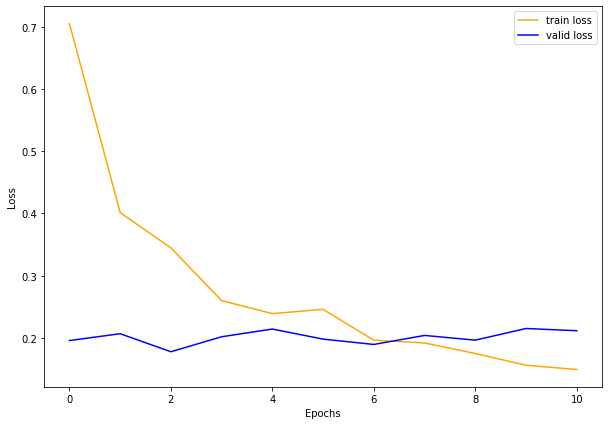

In [5]:
# Plot the graph of the train_loss
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss[:11], color='orange', linestyle='-', 
    label='train loss'
)

plt.plot(
    valid_loss[:11], color='blue', linestyle='-', 
    label='valid loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Discuss results
<!-- https://imgur.com/a/Z0Y7NEM -->
Epoch 10 Learning rate 0.25

<img src="https://i.imgur.com/E7zrPss.jpg" alt="drawing"/>

Epoch 10 Learning rate 0.1

<img src="https://i.imgur.com/8aVCfC9.jpg" />

Epoch 10 Learning rate 0.05

<img src="https://i.imgur.com/GZTHY3b.jpg" />

Epoch 10 Learning rate 0.025

<img src="https://i.imgur.com/rg89eAo.jpg" />

Epoch 60 Learning rate 0.001

<img src="https://i.imgur.com/gEv4TvX.jpg" />

The photos shown here were copied and pasted from `Graphing the result of the training loss and validation loss of the triple loss function` section whereby the learning rate were adjusted. As you can see, the lower the learning rate, the lower the loss value overall for the triple loss function. At some point of the graph, the valid loss may intersect with the training loss and further increase. This denotes overfitting. As you can see in the graph `epoch 60 learning rate 0.001` shows that the valid loss increases extremely, meaning that the network is overfitting to the training data.

In [6]:
# Save the weights of our new model
torch.save(model.state_dict(), 'misc/vggface_embedding_weights.pth')

In [8]:
model = VGGFace(in_channels=3, init_weights=False)
feature_embedding = 128
num_features = model.linear_layers[-1].in_features
features = list(model.linear_layers.children())[:-1] # remove last layer
features.extend([nn.Linear(num_features, feature_embedding)]) # add our layer with 1024 outputs
model.linear_layers = nn.Sequential(*features)
model.load_state_dict(torch.load('misc/vggface_embedding_weights_10_01.pth', map_location="cpu"))

<All keys matched successfully>

## Test feature vector of our image and database

To test our facial recognition in a database, we had to create a database of feature embedding vectors of each face in a dataset. We used https://www.kaggle.com/datasets/jessicali9530/lfw-dataset the Labelled Faces in the wild Dataset to compare faces with each other and to find the K closest faces. What we do is we calculate the embedding vector of each face in the lfw dataset, and then compare the distance of the embedding vector of a face we want to recognise. The K closest faces should be outputted.

In [ ]:
# Extract the lfw_dataset folder in the zip folder downloaded https://www.kaggle.com/datasets/jessicali9530/lfw-dataset in the root directory
path = './lfw_dataset/lfw_funneled/'
list_of_images = []
for dirname in os.listdir(path):
    image_folder_path = os.path.join(path, dirname)
    for image in os.listdir(image_folder_path):
        img_dir = os.path.join(image_folder_path, image)
        img = Image.open(img_dir)
        img.save(os.path.join("database", image))


In [11]:
# face detector in photos using facenet-pytorch
# Getting database of feature vectors

import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
from PIL import Image
from torchvision import transforms
from tqdm import tqdm



tr = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(
                (0.367035294117647, 0.41083294117647057, 0.5066129411764705), 
                (1, 1, 1)
            )
        ])

mtcnn = MTCNN(image_size=224, margin=0)

path = './database' 
name_to_vector = {}
for img_name in tqdm(os.listdir('./database')):
    img = Image.open(os.path.join(path, img_name))
    #print(img_name)
    img_cropped = mtcnn(img, save_path=f'misc/face_dataset/{img_name}')
    if img_cropped is None:
        continue
    img_cropped = tr(img_cropped)
    name_to_vector[img_name] = F.normalize(model(img_cropped.unsqueeze(0))).detach().numpy()


100%|██████████| 9813/9813 [23:30<00:00,  6.96it/s]  


In the cell below, we find the person closest to JJ Reddick in the database.

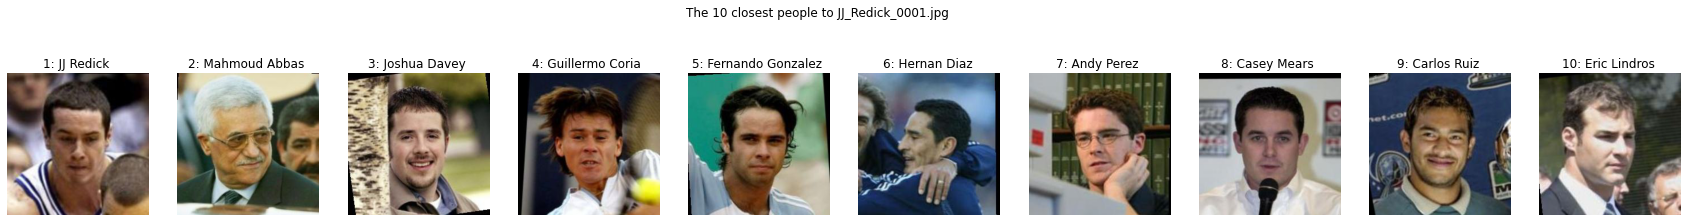

In [16]:
img_dir = './database'
test_dir = './database'
#test_dir = '/Users/namanhdang/Desktop/Uni/2022/COMP9444/COMP9444-project/database_tests/'
#img_dir = '/Users/namanhdang/Desktop/Uni/2022/COMP9444/COMP9444-project/misc/face_dataset/'

person = 'JJ_Redick_0001.jpg'

img = Image.open(os.path.join(test_dir, person)) 
img_cropped = mtcnn(img)
img_cropped = tr(img_cropped)
featureMatt = F.normalize(model(img_cropped.unsqueeze(0))).detach().numpy()

pairs = []


smallest_dist = float('inf')
for name, vector in name_to_vector.items():
    distance = np.linalg.norm(vector - featureMatt)
    pairs.append((name, distance))
    if distance < smallest_dist:
        smallest_dist = distance
        closest_person = name

sorted_pairs = sorted(pairs, key=lambda x: x[1])
k = 10
fig, ax = plt.subplots(1, k, figsize=(30, 4))
fig.suptitle(f"The {k} closest people to {person}")

for i in range(k):
    img = Image.open(os.path.join(img_dir, sorted_pairs[i][0]))
    ax[i].imshow(img)
    ax[i].set_axis_off()

    name = sorted_pairs[i][0]
    name = name.replace(".jpg", "")
    name = name.replace("_", " ")
    name = ''.join([i for i in name if not i.isdigit()])
    
    ax[i].set_title(f"{i+1}: {name}")

plt.show()


## Results of our Network discussed in `VGG_results.ipynb`.